<a href="https://colab.research.google.com/github/akansh12/Deep-Learning-for-imaging-EE5179/blob/main/Assignment_1/PA1_CS22Z003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification using MLP


By 
- Akansh Maurya (CS22Z003)

Tasks to to:
- Baseline: IP-h(500)-h(250)-h(100)-OP
- Activation functions for hidden layers: Sigmoid and for the Output layer it is softmax
- Gradient-Descent
- lr = 0.01, batch size = 64, epoch = 15
-  Extra marks for experimentations
- Glorot Initialization
- Plot the loss for 200 iterations
- Confustion matrix and classification report
1.1
- Use Tanh and RELU

Task 2:
- Use pytorch for the same
- Add L2 Regularization to it.

###Imports

In [ ]:
import tensorflow as tf
import torch
import keras
import torchvision
import numpy as np
from  matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Downloading the Dataset

In [ ]:
# source: https://keras.io/api/datasets/mnist/
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Reshaping the dataset

In [ ]:
x_train = np.array(x_train.reshape(x_train.shape[0], 784)).T
x_test = np.array(x_test.reshape(x_test.shape[0], 784)).T
x_train = (x_train/255.0).astype(np.float32)
x_test = (x_test/255.0).astype(np.float32)

In [ ]:
print("Train Dataset Shape: ", x_train.shape)
print("Train Target Vector Shape: ", y_train.shape) 
print("Test Dataset Shape:", x_test.shape)
print("Test Target Vector Shape", y_test.shape)

Train Dataset Shape:  (784, 60000)
Train Target Vector Shape:  (60000,)
Test Dataset Shape: (784, 10000)
Test Target Vector Shape (10000,)


9
7


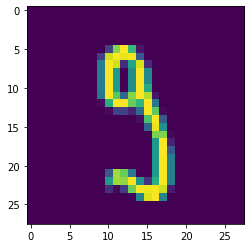

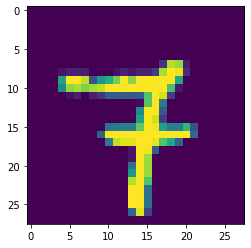

In [ ]:
plt.figure()
plt.imshow(x_train[:,48].reshape(28,28))
print(y_train[48])
plt.figure()
plt.imshow(x_test[:,75].reshape(28,28))
print(y_test[75])

### Model 

In [ ]:
class MLP():
  def __init__(self, epochs, num_input_nodes, hidden_layers, num_output_nodes, lr, optimizer, batch_size, activation_function = 'sigmoid', loss_type = 'cross_entropy', w_initial = 'glorot'):
    self.epochs = epochs
    self.lr = lr 
    self.optimizer = optimizer
    self.optimizer.lr = self.lr      
    self.batch_size = batch_size
    self.num_input_nodes = num_input_nodes
    self.hidden_layers = hidden_layers
    self.num_output_nodes = num_output_nodes
    self.loss_type = loss_type
    #Activation function
    self.activation_function = self.activation(activation_function)
    #parameter initialization
    self.params = self.initialization(weight_initialisation = w_initial)

  def activation(self, activation_function):

    if activation_function == 'sigmoid':
      return self.sigmoid
    if activation_function == 'tanh':
      return self.tanh
    if activation_function == 'ReLU':
      return self.relu

  def sigmoid(self,x, derivative = False):
    if derivative:
      return self.sigmoid(x)*(1-self.sigmoid(x))
    else:
      return 1/(1 + np.exp(-x))

  def tanh(self, x, derivative = False):
    if derivative:
      return 1 - self.tanh(x)**2
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

  def relu(self, x, derivative = False):
    if derivative:
      return (x>0)*1 
    return x*(x>0)


  def one_hot(self,y):
    v = np.zeros((self.num_output_nodes, len(y)))
    for i,j in enumerate(y):
      v[j,i] = 1
    return v

  def softmax(self,x,derivative = False):
    if derivative:
      return self.softmax(x)*(1- self.softmax(x))
    else:
      return (np.exp(x)/np.sum(np.exp(x), axis = 0))

  def loss(self, y_pred, y_true):
    if self.loss_type == 'cross_entropy':
      return -1*np.mean(np.multiply(y_true, np.log(y_pred))) # To Do: Optimize this using argmax

  def initialization(self, weight_initialisation = 'random'):
    w = []
    b = []

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*0.1)
    elif weight_initialisation == 'glorot':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*np.sqrt(6/(self.num_input_nodes+self.hidden_layers[0])))
    b.append(np.zeros((self.hidden_layers[0], 1))) 

    for i in range(1,len(self.hidden_layers)):
      if weight_initialisation == 'random':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*0.1)
      elif weight_initialisation == 'glorot':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*np.sqrt(6/(self.hidden_layers[i-1]+self.hidden_layers[i])))
      b.append(np.zeros((self.hidden_layers[i], 1)))

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*0.1)
    elif weight_initialisation == 'glorot':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*np.sqrt(6/(self.hidden_layers[len(self.hidden_layers)-1] + self.num_output_nodes)))
    b.append(np.zeros((self.num_output_nodes, 1)))

    return {'w':w, 'b':b}

  def compute_accuracy(self, x_test, y_test):
    from sklearn.metrics import accuracy_score
    out = self.feed_forward(x_test)
    pred = np.argmax(out, axis = 0)
    acc=accuracy_score(y_test, pred, normalize=True, sample_weight=None)
    return np.mean(pred == y_test)*100

  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.h.append(x)

    for i in range(0, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][-1],self.h[-1])+self.params['b'][-1])

    y_hat = self.softmax(self.a[-1])
    return y_hat

  def back_propagation(self, y_hat, y_true):
    self.da = [0]* len(self.a)
    self.dh = [0]* (len(self.h)-1)
    self.dw = [0]* len(self.params['w'])
    self.db = [0]* len(self.params['b'])

    self.da[-1] = -1*(y_true - y_hat)
    m = y_hat.shape[1]
    for i in range(len(self.params['w'])-1, 0, -1):
      self.dw[i] = 1./m * np.dot(self.da[i], self.h[i].T) 
      self.db[i] = 1./m * np.sum(self.da[i], axis = 1, keepdims = True)

      self.dh[i-1] = np.dot(self.params['w'][i].T, self.da[i])
      self.da[i-1] = np.multiply(self.dh[i-1], self.activation_function(self.da[i-1], derivative=True))
    self.dw[0] = 1./m * np.dot(self.da[0], self.h[0].T)
    self.db[0] = 1./m * np.sum(self.da[0], axis = 1, keepdims = True)

    return self.dw, self.db

  def train(self, x_train, y_train, x_test, y_test):
    N = x_train.shape[1]
    n_batches = int(np.floor(N / self.batch_size))
    train_iter_loss = []
    test_iter_loss = []
    train_epoch_loss = []
    for epoch in range(0, self.epochs):
      l = 0
      for batch in tqdm(range(0, n_batches)):
        x = x_train[:,batch*self.batch_size:self.batch_size+batch*self.batch_size]
        y = y_train[batch*self.batch_size:self.batch_size+batch*self.batch_size]
        y_hat = self.feed_forward(x)

        gW, gB = self.back_propagation(y_hat,self.one_hot(y))
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(y_hat, self.one_hot(y))
        if batch % 200 == 0:
          train_iter_loss.append(self.loss(self.feed_forward(x_train),self.one_hot(y_train)))
          test_iter_loss.append(self.loss(self.feed_forward(x_test),self.one_hot(y_test)))

      try:
        x = x_train[:,-1*N%n_batches:]
        y = y_train[-1*N%n_batches:]
        y_hat = self.feed_forward(x)
        gW, gB = self.back_propagation(y_hat, self.one_hot(y))
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(y_hat, y)
      except:
        pass

      train_epoch_loss.append(l/N)
      print(f"Epoch: {epoch}, Epoch-loss: {l/N}")
      print(f"Train Accuracy: {self.compute_accuracy(x_train, y_train)}")
      print(f"Test Accuracy: {self.compute_accuracy(x_test, y_test)}")

    return train_iter_loss, test_iter_loss, train_epoch_loss
    


### Optimizer

In [ ]:
### Optimizer
class SGD:
  ''' Stochastic Gradient Descent '''
  def __init__(self, lr = 0.001):
    self.lr = lr

  def update(self, params, gW, gB):
    W = np.array(params['w'], dtype = object)
    B = np.array(params['b'], dtype = object)
    W = W - self.lr * np.array(gW, dtype = object)
    B = B - self.lr * np.array(gB, dtype = object)

    return {'w':W.tolist(), 'b': B.tolist()}

# Question 1

### Experiment 1: Baseline
- h1 = 500, h2 = 250, h3 = 100
- Activation function: Sigmoid
- Loss: Cross entropy
- lr = 0.01
- batch_size = 64
- epoch = 15
- initialization: GLOROT 


In [ ]:
model = MLP(epochs = 15,num_input_nodes = 784, hidden_layers = [500, 250, 100],num_output_nodes = 10, lr = 0.01, optimizer = SGD(), batch_size= 64, w_initial = 'glorot', activation_function = 'sigmoid',loss_type='cross_entropy')
train_iter_loss, test_iter_loss, train_epoch_loss = model.train(x_train, y_train, x_test, y_test)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, Epoch-loss: 0.0035602351524768416
Train Accuracy: 56.80333333333333
Test Accuracy: 57.32000000000001


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Epoch-loss: 0.002975372906781143
Train Accuracy: 65.98333333333333
Test Accuracy: 66.9


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Epoch-loss: 0.0022557324681099955
Train Accuracy: 74.68833333333333
Test Accuracy: 75.39


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Epoch-loss: 0.0017716994717772196
Train Accuracy: 78.94333333333333
Test Accuracy: 79.69000000000001


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Epoch-loss: 0.0015165824374562954
Train Accuracy: 81.37
Test Accuracy: 82.07


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Epoch-loss: 0.001374225042922304
Train Accuracy: 83.22500000000001
Test Accuracy: 84.26


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Epoch-loss: 0.001287158054280488
Train Accuracy: 84.68
Test Accuracy: 85.48


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Epoch-loss: 0.0012295615340546509
Train Accuracy: 85.845
Test Accuracy: 86.49


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Epoch-loss: 0.0011885524657031252
Train Accuracy: 86.69166666666666
Test Accuracy: 87.18


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Epoch-loss: 0.001157594968736404
Train Accuracy: 87.44666666666666
Test Accuracy: 87.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Epoch-loss: 0.0011333621077735207
Train Accuracy: 88.04333333333332
Test Accuracy: 88.37


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Epoch-loss: 0.001114079475297138
Train Accuracy: 88.50666666666666
Test Accuracy: 88.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Epoch-loss: 0.00109868101344152
Train Accuracy: 88.88833333333334
Test Accuracy: 89.13


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Epoch-loss: 0.0010864037595176975
Train Accuracy: 89.19833333333334
Test Accuracy: 89.4


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Epoch-loss: 0.001076621102719078
Train Accuracy: 89.45666666666666
Test Accuracy: 89.72


#### Iteration Loss Plot

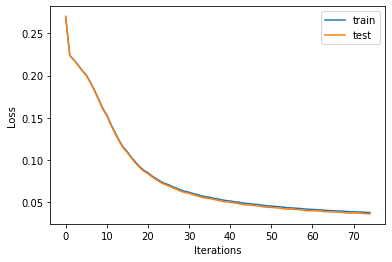

In [ ]:
plt.plot(train_iter_loss, label = 'train')
plt.plot(test_iter_loss, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Confusion matrix

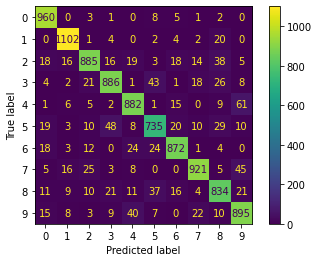

In [ ]:
y_test_pred = model.feed_forward(x_test)
y_test_pred = np.argmax(y_test_pred, axis = 0)
cm = confusion_matrix(y_test, y_test_pred, labels=list(range(0,10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(0,10)))
disp.plot()

Classification Report

In [ ]:
print(classification_report(y_test.tolist(), y_test_pred.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.91      0.86      0.88      1032
           3       0.89      0.88      0.89      1010
           4       0.89      0.90      0.89       982
           5       0.85      0.82      0.84       892
           6       0.92      0.91      0.91       958
           7       0.93      0.90      0.91      1028
           8       0.85      0.86      0.85       974
           9       0.86      0.89      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Accuracy

In [ ]:
print(f"Train Accuracy: {model.compute_accuracy(x_train, y_train)}")
print(f"Test Accuracy: {model.compute_accuracy(x_test, y_test)}")

Train Accuracy: 89.45666666666666
Test Accuracy: 89.72


# Question 1.1

### Experiment 2: Baseline with Tanh
- h1 = 500, h2 = 250, h3 = 100
- Activation function: **Tanh**
- Loss: Cross entropy
- lr = 0.01
- batch_size = 64
- epoch = 15
- initialization: GLOROT 


In [ ]:
model = MLP(epochs = 15,num_input_nodes = 784, hidden_layers = [500, 250, 100],num_output_nodes = 10, lr = 0.01, optimizer = SGD(), batch_size= 64, w_initial = 'glorot', activation_function = 'tanh',loss_type='cross_entropy')
train_iter_loss, test_iter_loss, train_epoch_loss = model.train(x_train, y_train, x_test, y_test)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, Epoch-loss: 0.001240191937749045
Train Accuracy: 90.015
Test Accuracy: 90.25


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Epoch-loss: 0.0010952894289198236
Train Accuracy: 91.08666666666667
Test Accuracy: 91.2


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Epoch-loss: 0.0010778886213054124
Train Accuracy: 91.67333333333333
Test Accuracy: 91.62


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Epoch-loss: 0.0010665697064195345
Train Accuracy: 92.04166666666667
Test Accuracy: 91.95


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Epoch-loss: 0.0010574088565152798
Train Accuracy: 92.4
Test Accuracy: 92.07


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Epoch-loss: 0.0010495233636310438
Train Accuracy: 92.63
Test Accuracy: 92.25999999999999


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Epoch-loss: 0.0010426057941916864
Train Accuracy: 92.85666666666667
Test Accuracy: 92.44


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Epoch-loss: 0.0010365329102476467
Train Accuracy: 92.98166666666667
Test Accuracy: 92.62


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Epoch-loss: 0.001031236236809687
Train Accuracy: 93.13166666666667
Test Accuracy: 92.71000000000001


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Epoch-loss: 0.001026656036705366
Train Accuracy: 93.31166666666667
Test Accuracy: 92.96


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Epoch-loss: 0.0010227268988899992
Train Accuracy: 93.42166666666667
Test Accuracy: 93.17999999999999


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Epoch-loss: 0.0010193796496780444
Train Accuracy: 93.53833333333334
Test Accuracy: 93.28


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Epoch-loss: 0.0010165464498109794
Train Accuracy: 93.60833333333333
Test Accuracy: 93.28999999999999


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Epoch-loss: 0.001014163691438047
Train Accuracy: 93.70833333333334
Test Accuracy: 93.35


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Epoch-loss: 0.0010121749697859863
Train Accuracy: 93.765
Test Accuracy: 93.32000000000001


Iteration Loss Plot

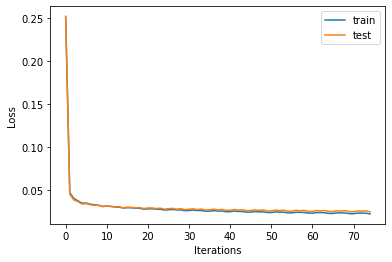

In [ ]:
plt.plot(train_iter_loss, label = 'train')
plt.plot(test_iter_loss, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Confusion matix

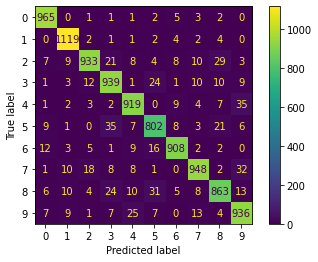

In [ ]:
y_test_pred = model.feed_forward(x_test)
y_test_pred = np.argmax(y_test_pred, axis = 0)
cm = confusion_matrix(y_test, y_test_pred, labels=list(range(0,10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(0,10)))
disp.plot()

Classification Report



In [ ]:
print(classification_report(y_test.tolist(), y_test_pred.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.95      0.90      0.93      1032
           3       0.90      0.93      0.92      1010
           4       0.93      0.94      0.93       982
           5       0.90      0.90      0.90       892
           6       0.96      0.95      0.95       958
           7       0.95      0.92      0.93      1028
           8       0.91      0.89      0.90       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Accuracy

In [ ]:
print(f"Train Accuracy: {model.compute_accuracy(x_train, y_train)}")
print(f"Test Accuracy: {model.compute_accuracy(x_test, y_test)}")

Train Accuracy: 93.765
Test Accuracy: 93.32000000000001


### Experiment 3: Baseline with ReLu
- h1 = 500, h2 = 250, h3 = 100
- Activation function: **ReLU**
- Loss: Cross entropy
- lr = 0.01
- batch_size = 64
- epoch = 15
- initialization: GLOROT 


In [ ]:
model = MLP(epochs = 15,num_input_nodes = 784, hidden_layers = [500, 250, 100],num_output_nodes = 10, lr = 0.01, optimizer = SGD(), batch_size= 64, w_initial = 'glorot', activation_function = 'ReLU',loss_type='cross_entropy')
train_iter_loss, test_iter_loss, train_epoch_loss = model.train(x_train, y_train, x_test, y_test)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, Epoch-loss: 0.0032251206354142366
Train Accuracy: 58.58833333333333
Test Accuracy: 59.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Epoch-loss: 0.002078292872087152
Train Accuracy: 67.92666666666666
Test Accuracy: 68.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Epoch-loss: 0.0018241121678241432
Train Accuracy: 71.14666666666668
Test Accuracy: 72.05


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Epoch-loss: 0.0017128569145571585
Train Accuracy: 72.81
Test Accuracy: 73.53


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Epoch-loss: 0.0016495470902938541
Train Accuracy: 73.86666666666667
Test Accuracy: 74.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Epoch-loss: 0.0016083121673480022
Train Accuracy: 74.62833333333333
Test Accuracy: 75.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Epoch-loss: 0.0015791405119295065
Train Accuracy: 75.17166666666667
Test Accuracy: 76.23


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Epoch-loss: 0.0015573198184942337
Train Accuracy: 75.70166666666667
Test Accuracy: 76.64999999999999


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Epoch-loss: 0.0015403325155339538
Train Accuracy: 76.045
Test Accuracy: 77.11


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Epoch-loss: 0.0015267070040653763
Train Accuracy: 76.35166666666666
Test Accuracy: 77.42999999999999


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Epoch-loss: 0.0015155228642097995
Train Accuracy: 76.58833333333334
Test Accuracy: 77.7


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Epoch-loss: 0.0015061731346038484
Train Accuracy: 76.835
Test Accuracy: 77.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Epoch-loss: 0.0014982401785200528
Train Accuracy: 77.065
Test Accuracy: 77.9


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Epoch-loss: 0.001491426433130764
Train Accuracy: 77.25999999999999
Test Accuracy: 78.19


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Epoch-loss: 0.0014855136345705807
Train Accuracy: 77.41333333333333
Test Accuracy: 78.29


Iteration Loss Plot

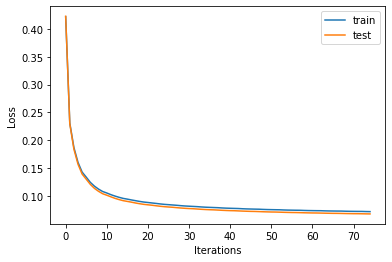

In [ ]:
plt.plot(train_iter_loss, label = 'train')
plt.plot(test_iter_loss, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Confusion matix

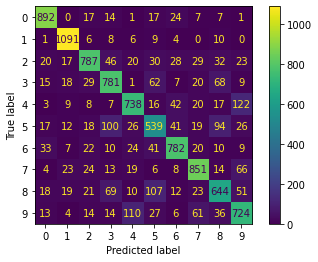

In [ ]:
y_test_pred = model.feed_forward(x_test)
y_test_pred = np.argmax(y_test_pred, axis = 0)
cm = confusion_matrix(y_test, y_test_pred, labels=list(range(0,10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(0,10)))
disp.plot()

Classification Report


In [ ]:
print(classification_report(y_test.tolist(), y_test_pred.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       980
           1       0.91      0.96      0.93      1135
           2       0.83      0.76      0.80      1032
           3       0.74      0.77      0.75      1010
           4       0.77      0.75      0.76       982
           5       0.63      0.60      0.62       892
           6       0.82      0.82      0.82       958
           7       0.81      0.83      0.82      1028
           8       0.69      0.66      0.68       974
           9       0.70      0.72      0.71      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



Accuracy

In [ ]:
print(f"Train Accuracy: {model.compute_accuracy(x_train, y_train)}")
print(f"Test Accuracy: {model.compute_accuracy(x_test, y_test)}")

Train Accuracy: 77.41333333333333
Test Accuracy: 78.29


Observations 



1.   Training the model with tanH activation function took the most time, with avg of 64 seconds for one epoch followed by sigmoid with 41 seconds and RelU with 30 seconds for one epochs. 
2.   The convergance rate of TanH is much more faster(early as in epochs), it gets the accuracy of 90 % on test set by the first epoch. 

3.   By the end of 15 epochs **Tanh** performed the best, with test accuracy of 93.32 %.



# Question 2

Using Pytorch

In [10]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [11]:
from torchvision import datasets
import torchvision.transforms as transforms

In [12]:
transform =transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False)

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

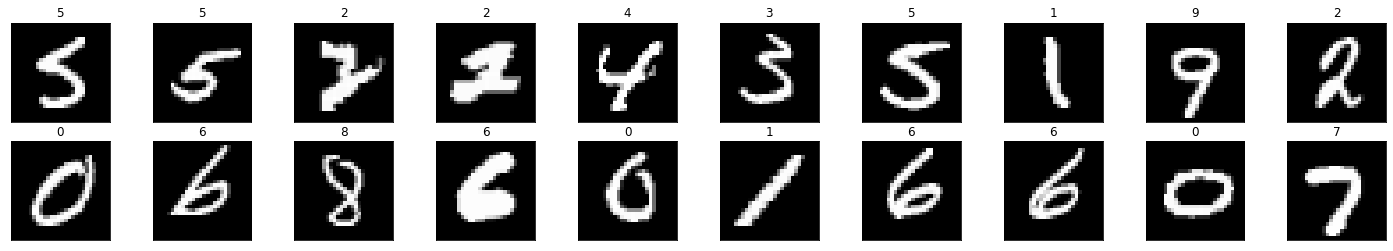

In [15]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### Model defination

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(784, 500)
    self.fc2 = nn.Linear(500, 250)
    self.fc3 = nn.Linear(250, 100)
    self.fc4 = nn.Linear(100, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)


### Loss function and Optimizer

No use of softmax because it is already there in the Pytoch implementation of Cross Entropy. 

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 15
train_epoch_loss = []
train_iter_loss = []
test_iter_loss = []
for epoch in range(epochs):
  l = 0
  for i, (data, target) in tqdm(enumerate(train_loader)):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    l+= loss.item()
    if i % 200 == 0:
      with torch.no_grad():
        l = 0
        model.eval()
        train_l = 0
        for x_train, y_train in train_loader:
          output = model(x_train)
          loss_1 = criterion(output, y_train)
          train_l += loss_1.item()
        train_iter_loss.append(train_l/len(train_loader))
        test_l = 0
        for x_test, y_test in test_loader:
          output = model(x_test)
          loss_1 = criterion(output, y_test)
          test_l += loss_1.item()
        test_iter_loss.append(test_l/len(test_loader))
  train_epoch_loss.append(l/len(train_loader))

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        l/len(train_loader)
        ))


0it [00:00, ?it/s]

Epoch: 1 	Training Loss: 0.033746


0it [00:00, ?it/s]

Epoch: 2 	Training Loss: 0.026559


0it [00:00, ?it/s]

Epoch: 3 	Training Loss: 0.022151


0it [00:00, ?it/s]

Epoch: 4 	Training Loss: 0.020246


0it [00:00, ?it/s]

Epoch: 5 	Training Loss: 0.017604


0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 0.014503


0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 0.015175


0it [00:00, ?it/s]

Epoch: 8 	Training Loss: 0.015244


0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 0.015413


0it [00:00, ?it/s]

Epoch: 10 	Training Loss: 0.013720


0it [00:00, ?it/s]

Epoch: 11 	Training Loss: 0.015870


0it [00:00, ?it/s]

Epoch: 12 	Training Loss: 0.012048


0it [00:00, ?it/s]

Epoch: 13 	Training Loss: 0.017922


0it [00:00, ?it/s]

Epoch: 14 	Training Loss: 0.012483


0it [00:00, ?it/s]

Epoch: 15 	Training Loss: 0.011348


Iteration loss plot

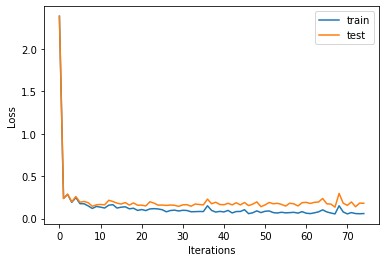

In [ ]:
plt.plot(train_iter_loss, label = 'train')
plt.plot(test_iter_loss, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

### Testing

In [ ]:
y_train_label = train_data.targets.numpy()
y_test_label = test_data.targets.numpy()
y_train_pred = []
y_test_pred = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle= False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False)

with torch.no_grad():
  model.eval()
  for x_train, y_train in train_loader:
    output = model(x_train)
    y_train_pred.extend(torch.argmax(output, axis = 1).tolist())

  for x_test, y_test in test_loader:
    output = model(x_test)
    y_test_pred.extend(torch.argmax(output, axis = 1).tolist())

Confusion matrix

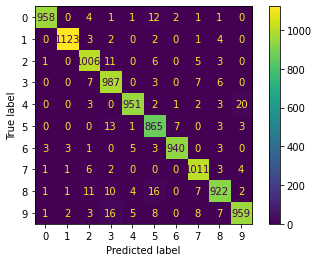

In [ ]:
cm = confusion_matrix(y_test_label, y_test_pred, labels=list(range(0,10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(0,10)))
disp.plot()

Classification report

In [ ]:
print(classification_report(y_test_label, y_test_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.94      0.97      0.96       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.95      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(f"Train Accuracy: {accuracy_score(y_train_label, y_train_pred, normalize=True, sample_weight=None)}")
print(f"Test Accuracy: {accuracy_score(y_test_label, y_test_pred, normalize=True, sample_weight=None)}")

Train Accuracy: 0.9860833333333333
Test Accuracy: 0.9722


# Regularization 
- L2 regularization using Pytoch

In Pytorch, we can complement L2 regularization in the loss function by changing lamda in optimizer, particularly Add a weight_decay parameter to the optimizer for L2 regularization. Documentation: https://pytorch.org/docs/stable/optim.html

In [26]:
model = MLP()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [27]:
epochs = 15
train_epoch_loss = []
train_iter_loss = []
test_iter_loss = []
for epoch in range(epochs):
  l = 0
  for i, (data, target) in tqdm(enumerate(train_loader)):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    l+= loss.item()
    if i % 200 == 0:
      with torch.no_grad():
        l = 0
        model.eval()
        train_l = 0
        for x_train, y_train in train_loader:
          output = model(x_train)
          loss_1 = criterion(output, y_train)
          train_l += loss_1.item()
        train_iter_loss.append(train_l/len(train_loader))
        test_l = 0
        for x_test, y_test in test_loader:
          output = model(x_test)
          loss_1 = criterion(output, y_test)
          test_l += loss_1.item()
        test_iter_loss.append(test_l/len(test_loader))
  train_epoch_loss.append(l/len(train_loader))

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        l/len(train_loader)
        ))


0it [00:00, ?it/s]

Epoch: 1 	Training Loss: 0.024536


0it [00:00, ?it/s]

Epoch: 2 	Training Loss: 0.020040


0it [00:00, ?it/s]

Epoch: 3 	Training Loss: 0.019182


0it [00:00, ?it/s]

Epoch: 4 	Training Loss: 0.019883


0it [00:00, ?it/s]

Epoch: 5 	Training Loss: 0.015130


0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 0.017538


0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 0.015842


0it [00:00, ?it/s]

Epoch: 8 	Training Loss: 0.013793


0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 0.016154


0it [00:00, ?it/s]

Epoch: 10 	Training Loss: 0.013715


0it [00:00, ?it/s]

Epoch: 11 	Training Loss: 0.013078


0it [00:00, ?it/s]

Epoch: 12 	Training Loss: 0.011117


0it [00:00, ?it/s]

Epoch: 13 	Training Loss: 0.014520


0it [00:00, ?it/s]

Epoch: 14 	Training Loss: 0.012413


0it [00:00, ?it/s]

Epoch: 15 	Training Loss: 0.012496


Iteration Loss Plot

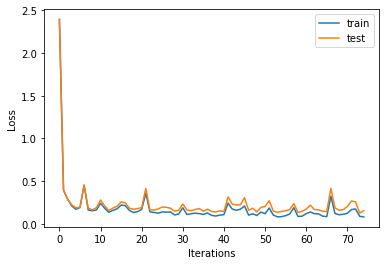

In [28]:
plt.plot(train_iter_loss, label = 'train')
plt.plot(test_iter_loss, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Testing 

In [31]:
y_train_label = train_data.targets.numpy()
y_test_label = test_data.targets.numpy()
y_train_pred = []
y_test_pred = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle= False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False)

with torch.no_grad():
  model.eval()
  for x_train, y_train in train_loader:
    output = model(x_train)
    y_train_pred.extend(torch.argmax(output, axis = 1).tolist())

  for x_test, y_test in test_loader:
    output = model(x_test)
    y_test_pred.extend(torch.argmax(output, axis = 1).tolist())

Confusion matrix

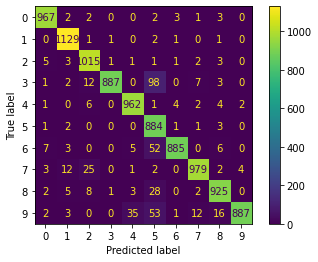

In [30]:
cm = confusion_matrix(y_test_label, y_test_pred, labels=list(range(0,10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(0,10)))
disp.plot()

Classification Report

In [32]:
print(classification_report(y_test_label, y_test_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.98      0.97      1032
           3       1.00      0.88      0.93      1010
           4       0.96      0.98      0.97       982
           5       0.79      0.99      0.88       892
           6       0.99      0.92      0.95       958
           7       0.97      0.95      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.99      0.88      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.95      0.95     10000



Acccuracy

In [33]:
from sklearn.metrics import accuracy_score

print(f"Train Accuracy: {accuracy_score(y_train_label, y_train_pred, normalize=True, sample_weight=None)}")
print(f"Test Accuracy: {accuracy_score(y_test_label, y_test_pred, normalize=True, sample_weight=None)}")

Train Accuracy: 0.9623166666666667
Test Accuracy: 0.952


PDF convertion

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/PA1 CS22Z003.ipynb"